# Geometric Multigrid for 2D Poisson
 
Poisson Equation:

\begin{align*}
\Delta u &= f, & \Omega \\
u &= 0, & \partial \Omega
\end{align*}

Discretizing with finite differences on a regular 2D mesh yields a 4, -1 stencil.

In [41]:
# Import some python libraries we need
import numpy as np
import matplotlib.pyplot as plt

# Size of the fine-grid problem
N = 256
N_c = int(N/2)

# 1D Model problem
def ModelProblem1D(N):
    A = np.diag(2*np.ones(N-1)) + np.diag(-1*np.ones(N-2),k=-1) + np.diag(-1*np.ones(N-2),k=1) 
    return A*N*N

A = ModelProblem1D(N)
A_c = ModelProblem1D(int(N/2))
# print(A)
# print(A_c)

# Define a random solution and corresponding right-hand side
u_final = np.random.rand(N-1)
f = np.dot(A,u_final)
u = np.zeros((N-1,))

# Define a constant right-hand side and corresponding solution
# f = np.ones(N-1)
# u_final = np.linalg.solve(A,f)
# u = np.zeros(N-1)

# Define a zero right-hand side and random initial guess
# f = np.zeros(N-1)
# u_final = np.zeros(N-1)
# u = -1 + 2*np.random.rand(N)
# u = np.cos(np.arange(N)*np.pi)

# Initialize iteration count and next iterate
# u_next = u.copy()
# i = 0
# print(u)

In [5]:
def GaussSeidel(A,u,f):
    for i in range(len(u)):
        u[i] = (1.0/A[i,i])*(f[i] - np.dot(A[i,:],u) + A[i,i]*u[i])

In [24]:
# Linear interpolation in 1D
def LinearInterpolation1D(N):
    N_c = int(N/2)
    P = np.zeros((N-1,N_c-1))
    P[0,0] = 0.5
    P[N-2,N_c-2] = 0.5
    for i in range(2,N-1):
        if i % 2 == 0:
            P[i-1,int((i-1)/2)] = 1
        else:
            P[i-1,int((i-2)/2)] = 0.5
            P[i-1,int((i)/2)] = 0.5
    return P

P = LinearInterpolation1D(N)
# print(P)

In [7]:
# Restriction by injection 1D
def RestrictionInjection1D(N):
    N_c = int(N/2)
    R = np.zeros((N_c-1,N-1))
    for i in range(N_c-1):
        R[i,2*i+1] = 1
    return R

R_I = RestrictionInjection1D(N)
# print(R_I)

In [8]:
# Restriction by full-weighting
def RestrictionFullWeighting1D(N):
    P = LinearInterpolation1D(N)
    R = 0.5*P.transpose()
    return R

R = RestrictionFullWeighting1D(N)
# print(R_FW)

In [12]:
# Verify that rediscrestization is equivalent to A_c = RAP when R is full-weighting
print(A_c)
print(np.dot(R, np.dot(A,P)))

[[128. -64.   0.   0.   0.   0.   0.]
 [-64. 128. -64.   0.   0.   0.   0.]
 [  0. -64. 128. -64.   0.   0.   0.]
 [  0.   0. -64. 128. -64.   0.   0.]
 [  0.   0.   0. -64. 128. -64.   0.]
 [  0.   0.   0.   0. -64. 128. -64.]
 [  0.   0.   0.   0.   0. -64. 128.]]
[[128. -64.   0.   0.   0.   0.   0.]
 [-64. 128. -64.   0.   0.   0.   0.]
 [  0. -64. 128. -64.   0.   0.   0.]
 [  0.   0. -64. 128. -64.   0.   0.]
 [  0.   0.   0. -64. 128. -64.   0.]
 [  0.   0.   0.   0. -64. 128. -64.]
 [  0.   0.   0.   0.   0. -64. 128.]]


[0.86720753 0.34727297 0.24452815 0.86505594 0.84088368 0.57853698
 0.71275637 0.90136712 0.39185724 0.63300527 0.217009   0.50298319
 0.08595496 0.90479283 0.59490111]
[0.86720753 0.34727297 0.24452815 0.86505594 0.84088368 0.57853698
 0.71275637 0.90136712 0.39185724 0.63300527 0.217009   0.50298319
 0.08595496 0.90479283 0.59490111]


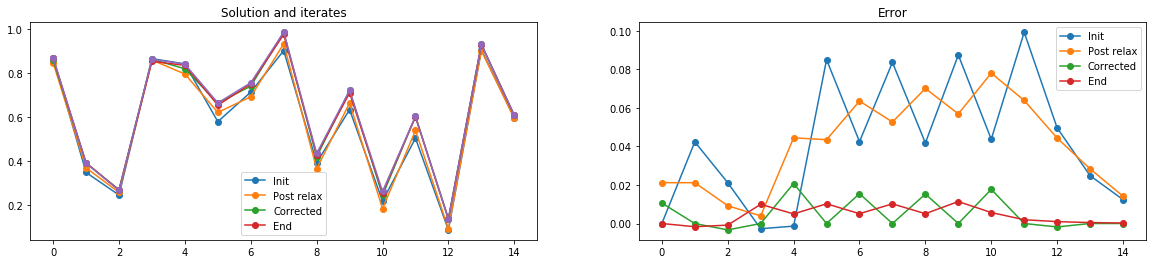

In [33]:
# Two-grid cycle
u_init = u.copy()
GaussSeidel(A,u,f) # fine-grid relax
u_post_relax = u.copy()
r = f - np.dot(A,u) # residual calculation
r_c = np.dot(R,r) # residual restriction
e_c = np.linalg.solve(A_c, r_c) # coarse-grid solve
e = np.dot(P,e_c) # interpolate correction
u = u + e # add correction
u_corrected = u.copy()
GaussSeidel(A,u,f) # fine-grid relax

# Plot progress toward solution
plt.subplots(figsize=(20, 4))
plt.subplot(1,2,1)
plt.title('Solution and iterates')
plt.plot(u_init,'-o')
plt.plot(u_post_relax,'-o')
plt.plot(u_corrected,'-o')
plt.plot(u,'-o')
plt.plot(u_final,'-o')
plt.legend(['Init','Post relax','Corrected','End'])

# Plot error
plt.subplot(1,2,2)
plt.title('Error')
plt.plot(u_final - u_init,'-o')
plt.plot(u_final - u_post_relax,'-o')
plt.plot(u_final - u_corrected,'-o')
plt.plot(u_final - u,'-o')
plt.legend(['Init','Post relax','Corrected','End'])
plt.show()

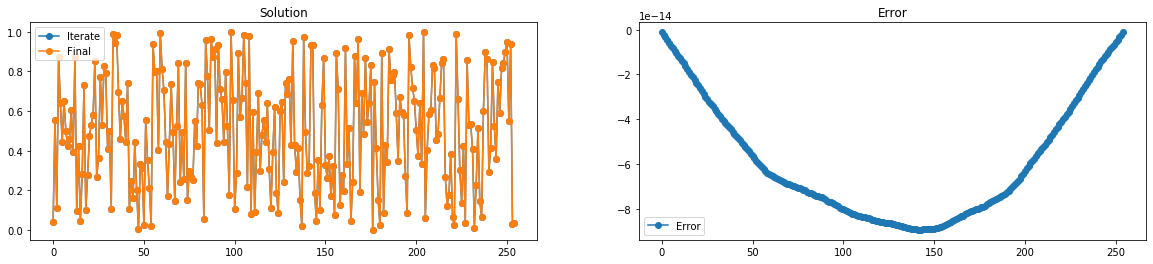

In [44]:
# V-cycle

# Setup the hierarchy
N_fine = N
num_levels = 1
A_array = [A]
u_array = [u]
f_array = [f]
P_array = []
R_array = []
while N_fine > 4:
    P_array.append( LinearInterpolation1D(N_fine) )
    R_array.append( RestrictionFullWeighting1D(N_fine) )
    N_fine = int(N_fine/2)
    A_array.append( ModelProblem1D(N_fine) )
    u_array.append( np.zeros(N_fine-1) )
    f_array.append( np.zeros(N_fine-1) )
    num_levels = num_levels + 1


# Do the V-cycle

# Downsweep
for i in range(num_levels-1):
    GaussSeidel(A_array[i],u_array[i],f_array[i]) # relax
    f_array[i+1] = np.dot( R_array[i] , f_array[i] - np.dot(A_array[i],u_array[i]) ) # residual restriction
    u_array[i+1].fill(0)

u = np.linalg.solve(A, f) # coarse-grid solve

for i in range(num_levels - 2, -1, -1):
    u_array[i] = u_array[i] + np.dot(P_array[i],u_array[i+1]) # interpolate and add correction
    GaussSeidel(A_array[i],u_array[i],f_array[i]) # relax

# Plot progress toward solution
plt.subplots(figsize=(20, 4))
plt.subplot(1,2,1)
plt.title('Solution')
plt.plot(u,'-o')
plt.plot(u_final,'-o')
plt.legend(['Iterate','Final'])

# Plot error
plt.subplot(1,2,2)
plt.title('Error')
plt.plot(u_final - u,'-o')
plt.legend(['Error'])